In [1]:
#Imports
import os
import sys
import glob
import torch
import torchvision
import pandas as pd
from tqdm import tqdm
from torchvision.models import alexnet

import numpy    as np
import datetime as dt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot   as plt

from PIL               import Image
from torch.utils.data  import Dataset
from torch.autograd    import Variable
from torch.optim       import lr_scheduler

from torch.utils.data  import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision       import transforms, datasets, models
from os                import listdir, makedirs, getcwd, remove
from os.path           import isfile, join, abspath, exists, isdir, expanduser


%matplotlib inline

In [2]:
data_path = "/kaggle/input/ammi-2023-convnets/"
train_path = join(data_path, "train/train")
test_path = join(data_path,"test/test")
extraimage_path = join(data_path, "extraimages/extraimages")


In [3]:
# Transformations for both the training and testing data
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Do data transforms here, Try many others
train_transforms  = transforms.Compose([
    transforms.Resize((580,580)),
    #transforms.CenterCrop(448),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees = 30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])


test_transforms = transforms.Compose([ transforms.Resize((580,580)),
                                       #transforms.Resize(255),
                                       #transforms.CenterCrop(448),
                                       transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



In [4]:
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
            
        return im.view(3, 580, 580), classCategory

In [5]:
train_data = CassavaDataset(train_path, transform=train_transforms)
test_data = CassavaDataset(test_path, transform=test_transforms)

In [6]:
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [7]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=8,
                                             sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=8,
                                             sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8)

In [8]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.manual_seed(random_seed) # fix the random seed
model = torchvision.models.resnext50_32x4d(pretrained=True)
# for p in model.parameters():
#     p.requires_grad = False
# set the final linear layer to the number of classes of the problem
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
hypergrad_lr = 1e-9
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-3)
hypergrad_optimizer = torch.optim.Adam(model.parameters(), lr=hypergrad_lr)

In [9]:
!pip install ttach

In [10]:
import ttach as tta


In [12]:
# Define the path to the folder containing the subfolders
path = train_path

# Get the list of subfolders
subfolders = [f.path for f in os.scandir(path) if f.is_dir()]

# Create a list to store the number of images in each subfolder
num_images = []

# Iterate over the subfolders and count the number of images
for subfolder in subfolders:
    num_images.append(len(os.listdir(subfolder)))
    
# Compute class weights
class_counts = num_images  # Number of samples per class
total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
class_weights = torch.FloatTensor(class_weights).to(device)

In [14]:
num_classes = 5
num_epochs = 10
learning_rate = 1e-4
hypergrad_lr = 1e-9

model1 = torchvision.models.resnext101_64x4d(pretrained=True)
model1.avgpool = nn.AdaptiveAvgPool2d((1, 1))
num_features = model1.fc.in_features
model1.fc = nn.Linear(num_features, num_classes)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
hypergrad_optimizer = torch.optim.Adam(model1.parameters(), lr=hypergrad_lr)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:06<00:00, 55.2MB/s] 


In [ ]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for features, target in data_loader:

            # Forward pass.
            output = model(features.to(device))

            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)

            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(valid_sampler)
    print(f'Test accuracy: {correct} / {len(valid_sampler)} ({percent:.0f}%)')
    #torch.save(model.state_dict(), 'model.ckpt')
    return percent

In [15]:
def train(model, criterion, data_loader, valid_loader, optimizer, num_epochs):
    """
    This Method runs the optimization loop for learning the parameters
    Method parameters:
    model: the model object.
    criterion: the loss function.
    data_loader: training data loader object.
    valid_loader: validation data loader object.
    optmizer: the optimizer object.
    num_epochs: number of training epochs.
    The function returns: 
    losses: a list that containes the loss for every epoch.
    training_accuracies: a list that containes the traning accuracy for every epoch.
    validation_accuracies: a list that containes the validation accuracy for every epoch.
    """
    # Move model to the device (CPU or GPU).
    model = model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    best_acc = 0

    # Losses list 
    losses = []
    # training acurracy list
    training_accuracies = []
    # validation acurracy list
    validation_accuracies = []

    print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
      
      # Make sure model is in training mode.
      model.train()  
      correct = 0
      # Loop over data.
      for batch_idx, (features, target) in enumerate(data_loader):
        torch.cuda.empty_cache()
        # Forward pass.
        output = model(features.to(device))
        loss = criterion(output.to(device), target.to(device))
        
        # Backward pass.
        optimizer.zero_grad()
        #hypergrad_optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #hypergrad_optimizer.step()
        
        # Compute the training accuracy
        with torch.no_grad():
          pred = output.argmax(dim=1, keepdim=True)
              
          # Count number of correct predictions.
          correct += pred.cpu().eq(target.view_as(pred)).sum().item()
      
      # NOTE: It is important to call .item() on the loss before summing.
        if ema_loss is None:
            ema_loss = loss.item()
        else:
            ema_loss += (loss.item() - ema_loss) * 0.01

      # Print out progress the end of epoch.
      #lr_sch.step()
      train_score = 100. * correct / len(data_loader.sampler)
      # Compute the validation accuracy
      valid_score = test(model, valid_loader)
      losses.append(ema_loss)
      training_accuracies.append(train_score)
      validation_accuracies.append(valid_score)
      if valid_score > best_acc:
            best_acc = valid_score
            torch.save(model, 'get_resnext101_weighted.pth')
      print('Epoch: {} \tLoss: {:.12f} \tTraining Accuracy: {:.12f} \t Validation Accuracy: {:.12f}'.format(epoch, ema_loss, train_score, valid_score),)

    return losses, training_accuracies, validation_accuracies

In [13]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [14]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [17]:
num_epochs = 10
losses, training_accuracies, validation_accuracies = train(model1, criterion, train_loader, valid_loader, optimizer, num_epochs)

----- Training Loop -----
----- Model Evaluation -----
Test accuracy: 1015 / 1131 (90%)
Epoch: 0 	Loss: 0.572170594369 	Training Accuracy: 74.784530386740 	 Validation Accuracy: 89.743589743590
----- Model Evaluation -----
Test accuracy: 1019 / 1131 (90%)
Epoch: 1 	Loss: 0.412880797000 	Training Accuracy: 84.994475138122 	 Validation Accuracy: 90.097259062776
----- Model Evaluation -----
Test accuracy: 1006 / 1131 (89%)
Epoch: 2 	Loss: 0.362752653725 	Training Accuracy: 87.535911602210 	 Validation Accuracy: 88.947833775420
----- Model Evaluation -----
Test accuracy: 987 / 1131 (87%)
Epoch: 3 	Loss: 0.294887941661 	Training Accuracy: 89.966850828729 	 Validation Accuracy: 87.267904509284
----- Model Evaluation -----
Test accuracy: 998 / 1131 (88%)
Epoch: 4 	Loss: 0.276968897734 	Training Accuracy: 91.447513812155 	 Validation Accuracy: 88.240495137047
----- Model Evaluation -----
Test accuracy: 1015 / 1131 (90%)
Epoch: 5 	Loss: 0.235982568811 	Training Accuracy: 90.850828729282 	 Valid

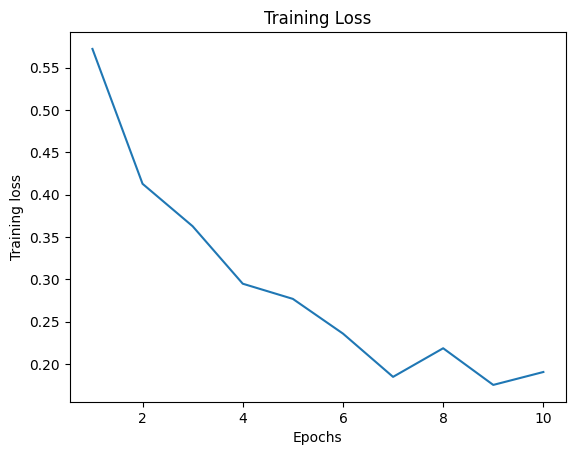

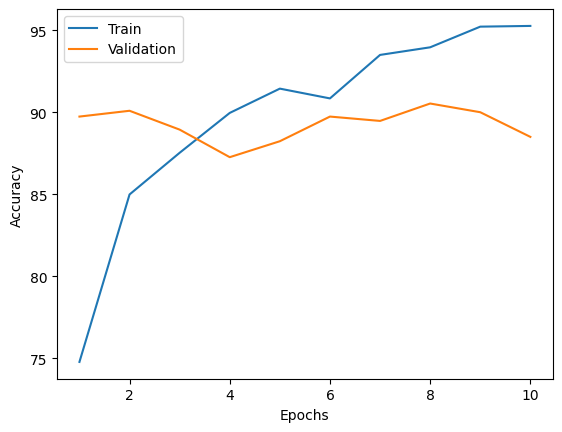

In [18]:
epochs = range(1, len(losses)+1)
plt.title("Training Loss")
plt.plot(epochs, losses)
plt.xlabel("Epochs")
plt.ylabel("Training loss")

plt.figure()
plt.plot(epochs, training_accuracies, label="Train")
plt.plot(epochs, validation_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


In [31]:
test(model1, valid_loader)

----- Model Evaluation -----
Test accuracy: 994 / 1131 (88%)


87.8868258178603

In [32]:
tta_model = tta.ClassificationTTAWrapper(model1, tta.aliases.five_crop_transform(500,500))

In [33]:
test(tta_model, valid_loader)

----- Model Evaluation -----
Test accuracy: 1000 / 1131 (88%)


88.41732979664015

In [24]:
tta_model2 = tta.ClassificationTTAWrapper(model1, tta.aliases.flip_transform())


In [25]:
test(tta_model2, valid_loader)

----- Model Evaluation -----
Test accuracy: 1028 / 1131 (91%)


90.89301503094606

In [19]:
loaded_mode = torch.load('/kaggle/working/get_resnext101_weighted.pth')

In [20]:
test(loaded_mode, valid_loader)#90.27

----- Model Evaluation -----
Test accuracy: 1024 / 1131 (91%)


90.53934571175951

In [21]:
tta_model = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.five_crop_transform(484,484))#90.27
test(tta_model, valid_loader)

----- Model Evaluation -----
Test accuracy: 1025 / 1131 (91%)


90.62776304155615

In [22]:
tta_model2 = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.flip_transform()) #90.98
test(tta_model2, valid_loader)


----- Model Evaluation -----
Test accuracy: 1033 / 1131 (91%)


91.33510167992927

In [23]:
tta_model = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.five_crop_transform(500,500)) #91.15
tta_model3 = tta.ClassificationTTAWrapper(tta_model, tta.aliases.flip_transform())
test(tta_model3, valid_loader)

----- Model Evaluation -----
Test accuracy: 1035 / 1131 (92%)


91.51193633952255

to run

In [28]:
tta_model4 = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.ten_crop_transform(500,500))#91.06
test(tta_model4, valid_loader)

----- Model Evaluation -----
Test accuracy: 1028 / 1131 (91%)


90.89301503094606

In [29]:
tta_model = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.five_crop_transform(500,500))#90.98
tta_model5 = tta.ClassificationTTAWrapper(tta_model, tta.aliases.ten_crop_transform(500,500))
tta_model6 = tta.ClassificationTTAWrapper(tta_model5, tta.aliases.flip_transform())
test(tta_model6, valid_loader)

----- Model Evaluation -----
Test accuracy: 1028 / 1131 (91%)


90.89301503094606

In [ ]:
def predict(model, loader):
    model.eval()
    test_dataloader =  loader
    preds = []
    with torch.no_grad():
        for test_images, test_labels in tqdm(test_dataloader):
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            output = model(test_images)

            _, predicted = torch.max(output, 1)
            preds.extend(predicted.cpu().data.numpy())


    return preds

In [24]:
preds6 = predict(tta_model3, test_loader)

100%|██████████| 472/472 [47:37<00:00,  6.05s/it]


In [30]:
preds7 = predict(tta_model2, test_loader)

100%|██████████| 472/472 [10:13<00:00,  1.30s/it]


In [26]:
name = [test_data.file_list[i][-1].split('/')[-1] for i in range(len(test_data.file_list)) ]

In [31]:
sample = pd.read_csv('/kaggle/input/ammi-2023-convnets/sample_submission_file.csv')
sample['Id'] = name
#preds = predict(model, test_loader)
mapping = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}
new_preds = [mapping[pred] for pred in preds7]
sample['Category'] = new_preds
sample.to_csv('submission_resnext101_tta_flip_weighted.csv', index=False)
sample.head()

,Category,Id
0,cbb,test-img-1448.jpg
1,cmd,test-img-768.jpg
2,cmd,test-img-3481.jpg
3,cmd,test-img-1475.jpg
4,cgm,test-img-2498.jpg


Image 580 and val 10%

In [15]:
num_classes = 5
num_epochs = 10
learning_rate = 2e-4
hypergrad_lr = 1e-9

model2 = torchvision.models.resnext101_64x4d(pretrained=True)
model2.avgpool = nn.AdaptiveAvgPool2d((1, 1))
num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, num_classes)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
hypergrad_optimizer = torch.optim.Adam(model2.parameters(), lr=hypergrad_lr)

In [16]:
def train(model, criterion, data_loader, valid_loader, optimizer, num_epochs):
    """
    This Method runs the optimization loop for learning the parameters
    Method parameters:
    model: the model object.
    criterion: the loss function.
    data_loader: training data loader object.
    valid_loader: validation data loader object.
    optmizer: the optimizer object.
    num_epochs: number of training epochs.
    The function returns: 
    losses: a list that containes the loss for every epoch.
    training_accuracies: a list that containes the traning accuracy for every epoch.
    validation_accuracies: a list that containes the validation accuracy for every epoch.
    """
    # Move model to the device (CPU or GPU).
    model = model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    best_acc = 0

    # Losses list 
    losses = []
    # training acurracy list
    training_accuracies = []
    # validation acurracy list
    validation_accuracies = []

    print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
      
      # Make sure model is in training mode.
      model.train()  
      correct = 0
      # Loop over data.
      for batch_idx, (features, target) in enumerate(data_loader):
        torch.cuda.empty_cache()
        # Forward pass.
        output = model(features.to(device))
        loss = criterion(output.to(device), target.to(device))
        
        # Backward pass.
        optimizer.zero_grad()
        #hypergrad_optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #hypergrad_optimizer.step()
        
        # Compute the training accuracy
        with torch.no_grad():
          pred = output.argmax(dim=1, keepdim=True)
              
          # Count number of correct predictions.
          correct += pred.cpu().eq(target.view_as(pred)).sum().item()
      
      # NOTE: It is important to call .item() on the loss before summing.
        if ema_loss is None:
            ema_loss = loss.item()
        else:
            ema_loss += (loss.item() - ema_loss) * 0.01

      # Print out progress the end of epoch.
      #lr_sch.step()
      train_score = 100. * correct / len(data_loader.sampler)
      # Compute the validation accuracy
      valid_score = test(model, valid_loader)
      losses.append(ema_loss)
      training_accuracies.append(train_score)
      validation_accuracies.append(valid_score)
      if valid_score > best_acc:
            best_acc = valid_score
            torch.save(model, 'get_resnext101_weighted_580_10percent.pth')
      print('Epoch: {} \tLoss: {:.12f} \tTraining Accuracy: {:.12f} \t Validation Accuracy: {:.12f}'.format(epoch, ema_loss, train_score, valid_score),)

    return losses, training_accuracies, validation_accuracies

In [17]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for features, target in data_loader:

            # Forward pass.
            output = model(features.to(device))

            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)

            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(valid_sampler)
    print(f'Test accuracy: {correct} / {len(valid_sampler)} ({percent:.0f}%)')
    #torch.save(model.state_dict(), 'model.ckpt')
    return percent

In [ ]:
num_epochs = 10
losses, training_accuracies, validation_accuracies = train(model2, criterion, train_loader, valid_loader, optimizer, num_epochs)

----- Training Loop -----
----- Model Evaluation -----
Test accuracy: 478 / 565 (85%)
Epoch: 0 	Loss: 0.602527877245 	Training Accuracy: 74.661166764879 	 Validation Accuracy: 84.601769911504
----- Model Evaluation -----
Test accuracy: 503 / 565 (89%)
Epoch: 1 	Loss: 0.452531006779 	Training Accuracy: 84.737772539776 	 Validation Accuracy: 89.026548672566
----- Model Evaluation -----
Test accuracy: 508 / 565 (90%)
Epoch: 2 	Loss: 0.369633237359 	Training Accuracy: 87.409153407975 	 Validation Accuracy: 89.911504424779
----- Model Evaluation -----
Test accuracy: 508 / 565 (90%)
Epoch: 3 	Loss: 0.363992551287 	Training Accuracy: 87.625220978197 	 Validation Accuracy: 89.911504424779
----- Model Evaluation -----
Test accuracy: 497 / 565 (88%)
Epoch: 4 	Loss: 0.308366814074 	Training Accuracy: 89.510901591043 	 Validation Accuracy: 87.964601769912
----- Model Evaluation -----
Test accuracy: 483 / 565 (85%)
Epoch: 5 	Loss: 0.323417683595 	Training Accuracy: 90.768021999607 	 Validation Accu

In [ ]:
epochs = range(1, len(losses)+1)
plt.title("Training Loss")
plt.plot(epochs, losses)
plt.xlabel("Epochs")
plt.ylabel("Training loss")

plt.figure()
plt.plot(epochs, training_accuracies, label="Train")
plt.plot(epochs, validation_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


In [ ]:
test(model2, valid_loader)

In [ ]:
loaded_mode = torch.load('/kaggle/working/get_resnext101_weighted_580_10percent.pth')

In [ ]:
test(loaded_mode, valid_loader)#90.27, 90.53

In [ ]:
tta_model = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.five_crop_transform(484,484))#90.27, 90,62
test(tta_model, valid_loader)

In [ ]:
tta_model2 = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.flip_transform()) #90.98, 91.33
test(tta_model2, valid_loader)

In [ ]:
tta_model4 = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.ten_crop_transform(500,500))#91.06, 90.89
test(tta_model4, valid_loader)

In [ ]:
tta_model = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.five_crop_transform(500,500)) #91.15, 91.51
tta_model3 = tta.ClassificationTTAWrapper(tta_model, tta.aliases.flip_transform())
test(tta_model3, valid_loader)

In [ ]:
tta_model = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.five_crop_transform(500,500))#90.98, 90.89
tta_model5 = tta.ClassificationTTAWrapper(tta_model, tta.aliases.ten_crop_transform(500,500))
tta_model6 = tta.ClassificationTTAWrapper(tta_model5, tta.aliases.flip_transform())
test(tta_model6, valid_loader)

In [ ]:
preds6 = predict(tta_model3, test_loader)

In [ ]:
name = [test_data.file_list[i][-1].split('/')[-1] for i in range(len(test_data.file_list)) ]

In [ ]:
sample = pd.read_csv('/kaggle/input/ammi-2023-convnets/sample_submission_file.csv')
sample['Id'] = name
#preds = predict(model, test_loader)
mapping = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}
new_preds = [mapping[pred] for pred in preds7]
sample['Category'] = new_preds
sample.to_csv('submission_resnext101_tta_flip_weighted.csv', index=False)
sample.head()

In [33]:
preds = predict(tta_model3, test_loader)

100%|██████████| 472/472 [47:36<00:00,  6.05s/it]


In [36]:
sample = pd.read_csv('/kaggle/input/ammi-2023-convnets/sample_submission_file.csv')
sample['Id'] = name
#preds = predict(model, test_loader)
mapping = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}
new_preds = [mapping[pred] for pred in preds]
sample['Category'] = new_preds
sample.to_csv('submission_resnext101_tta_flip_crop.csv', index=False)
sample.head()

,Category,Id
0,cgm,test-img-1448.jpg
1,cmd,test-img-768.jpg
2,cmd,test-img-3481.jpg
3,cmd,test-img-1475.jpg
4,cgm,test-img-2498.jpg


In [37]:
preds = predict(tta_model2, test_loader)

100%|██████████| 472/472 [10:13<00:00,  1.30s/it]


In [38]:
sample = pd.read_csv('/kaggle/input/ammi-2023-convnets/sample_submission_file.csv')
sample['Id'] = name
#preds = predict(model, test_loader)
mapping = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}
new_preds = [mapping[pred] for pred in preds]
sample['Category'] = new_preds
sample.to_csv('submission_resnext101_tta_flip.csv', index=False)
sample.head()

,Category,Id
0,cgm,test-img-1448.jpg
1,cmd,test-img-768.jpg
2,cmd,test-img-3481.jpg
3,cmd,test-img-1475.jpg
4,cgm,test-img-2498.jpg


In [39]:
preds1 = predict(loaded_mode, test_loader)

100%|██████████| 472/472 [03:07<00:00,  2.51it/s]


In [40]:
sample = pd.read_csv('/kaggle/input/ammi-2023-convnets/sample_submission_file.csv')
sample['Id'] = name
#preds = predict(model, test_loader)
mapping = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}
new_preds = [mapping[pred] for pred in preds1]
sample['Category'] = new_preds
sample.to_csv('submission_resnext101_noflip_loaded.csv', index=False)
sample.head()

,Category,Id
0,cgm,test-img-1448.jpg
1,cmd,test-img-768.jpg
2,cmd,test-img-3481.jpg
3,cmd,test-img-1475.jpg
4,cgm,test-img-2498.jpg


In [ ]:
checkpoint = torch.load('')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [15]:
#image size 580
num_classes = 5
num_epochs = 8
learning_rate = 1e-4
hypergrad_lr = 1e-9

model2 = torchvision.models.resnext101_64x4d(pretrained=True)
model2.avgpool = nn.AdaptiveAvgPool2d((1, 1))
num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
hypergrad_optimizer = torch.optim.Adam(model2.parameters(), lr=hypergrad_lr)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:04<00:00, 73.5MB/s] 


In [17]:
#image size 580
def train(model, criterion, data_loader, valid_loader, optimizer, num_epochs):
    """
    This Method runs the optimization loop for learning the parameters
    Method parameters:
    model: the model object.
    criterion: the loss function.
    data_loader: training data loader object.
    valid_loader: validation data loader object.
    optmizer: the optimizer object.
    num_epochs: number of training epochs.
    The function returns: 
    losses: a list that containes the loss for every epoch.
    training_accuracies: a list that containes the traning accuracy for every epoch.
    validation_accuracies: a list that containes the validation accuracy for every epoch.
    """
    # Move model to the device (CPU or GPU).
    model = model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    best_acc = 0

    # Losses list 
    losses = []
    # training acurracy list
    training_accuracies = []
    # validation acurracy list
    validation_accuracies = []

    print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
      
      # Make sure model is in training mode.
      model.train()  
      correct = 0
      # Loop over data.
      for batch_idx, (features, target) in enumerate(data_loader):
        torch.cuda.empty_cache()
        # Forward pass.
        output = model(features.to(device))
        loss = criterion(output.to(device), target.to(device))
        
        # Backward pass.
        optimizer.zero_grad()
        #hypergrad_optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #hypergrad_optimizer.step()
        
        # Compute the training accuracy
        with torch.no_grad():
          pred = output.argmax(dim=1, keepdim=True)
              
          # Count number of correct predictions.
          correct += pred.cpu().eq(target.view_as(pred)).sum().item()
      
      # NOTE: It is important to call .item() on the loss before summing.
        if ema_loss is None:
            ema_loss = loss.item()
        else:
            ema_loss += (loss.item() - ema_loss) * 0.01

      # Print out progress the end of epoch.
      #lr_sch.step()
      train_score = 100. * correct / len(data_loader.sampler)
      # Compute the validation accuracy
      valid_score = test(model, valid_loader)
      losses.append(ema_loss)
      training_accuracies.append(train_score)
      validation_accuracies.append(valid_score)
      if valid_score > best_acc:
            best_acc = valid_score
            torch.save(model, 'get_resnext101_580.pth')
      print('Epoch: {} \tLoss: {:.12f} \tTraining Accuracy: {:.12f} \t Validation Accuracy: {:.12f}'.format(epoch, ema_loss, train_score, valid_score),)

    return losses, training_accuracies, validation_accuracies

In [18]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for features, target in data_loader:

            # Forward pass.
            output = model(features.to(device))

            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)

            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(valid_sampler)
    print(f'Test accuracy: {correct} / {len(valid_sampler)} ({percent:.0f}%)')
    #torch.save(model.state_dict(), 'model.ckpt')
    return percent

In [ ]:
num_epochs = 8
losses, training_accuracies, validation_accuracies = train(model2, criterion, train_loader, valid_loader, optimizer, num_epochs)

----- Training Loop -----
----- Model Evaluation -----
Test accuracy: 1018 / 1131 (90%)
Epoch: 0 	Loss: 0.490502539303 	Training Accuracy: 77.878453038674 	 Validation Accuracy: 90.008841732980
----- Model Evaluation -----
Test accuracy: 1023 / 1131 (90%)
Epoch: 1 	Loss: 0.395925783190 	Training Accuracy: 87.867403314917 	 Validation Accuracy: 90.450928381963
----- Model Evaluation -----
Test accuracy: 1029 / 1131 (91%)
Epoch: 2 	Loss: 0.348607055317 	Training Accuracy: 89.790055248619 	 Validation Accuracy: 90.981432360743
----- Model Evaluation -----
Test accuracy: 1027 / 1131 (91%)
Epoch: 3 	Loss: 0.250442418689 	Training Accuracy: 91.712707182320 	 Validation Accuracy: 90.804597701149


In [ ]:

epochs = range(1, len(losses)+1)
plt.title("Training Loss")
plt.plot(epochs, losses)
plt.xlabel("Epochs")
plt.ylabel("Training loss")

plt.figure()
plt.plot(epochs, training_accuracies, label="Train")
plt.plot(epochs, validation_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


In [ ]:
test(model2, valid_loader)

In [ ]:
tta_model = tta.ClassificationTTAWrapper(model2, tta.aliases.five_crop_transform(500,500))

In [ ]:
test(tta_model, valid_loader)

In [ ]:
loaded_mode = torch.load('/kaggle/working/get_resnext101_580.pth')

In [ ]:
tta_model = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.five_crop_transform(512,512))
test(tta_model, valid_loader)

In [ ]:
tta_model2 = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.flip_transform())
test(tta_model2, valid_loader)

In [ ]:
tta_model = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.five_crop_transform(512,512))
tta_model3 = tta.ClassificationTTAWrapper(tta_model, tta.aliases.flip_transform())
test(tta_model3, valid_loader)

In [ ]:
tta_model4 = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.ten_crop_transform(512,512))
test(tta_model4, valid_loader)

In [ ]:
tta_model4 = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.ten_crop_transform(512,512))
test(tta_model4, valid_loader)

In [ ]:
tta_model = tta.ClassificationTTAWrapper(loaded_mode, tta.aliases.five_crop_transform(512,512))
tta_model5 = tta.ClassificationTTAWrapper(tta_model, tta.aliases.ten_crop_transform(512,512))
tta_model6 = tta.ClassificationTTAWrapper(tta_model5, tta.aliases.flip_transform())
test(tta_model6, valid_loader)

In [ ]:
preds6 = predict(tta_model4, test_loader)

In [ ]:
sample = pd.read_csv('/kaggle/input/ammi-2023-convnets/sample_submission_file.csv')
sample['Id'] = name
#preds = predict(model, test_loader)
mapping = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}
new_preds = [mapping[pred] for pred in preds]
sample['Category'] = new_preds
sample.to_csv('submission_resnext101_tta_flip_crop.csv', index=False)
sample.head()